## Imports
---

In [1]:
# Standard imports
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import pandas as pd
import json
import csv
import math

In [2]:
# Keras imports
from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.models import Model, Sequential, load_model, save_model
from tensorflow.python.keras.layers import Input, Dense, Dropout, Flatten, Reshape, Conv2D,RepeatVector, Conv2DTranspose, MaxPooling2D, Concatenate, Lambda,BatchNormalization, UpSampling2D, AveragePooling2D
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.losses import binary_crossentropy
from tensorflow.python.keras.layers.advanced_activations import LeakyReLU
from tensorflow.python.keras.backend import set_image_data_format
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, ParameterGrid
from tensorflow.python.framework.ops import disable_eager_execution
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
import scipy.sparse as sparse
from sklearn.model_selection import train_test_split 
from tensorflow.python.keras.callbacks import EarlyStopping,ModelCheckpoint,ReduceLROnPlateau, TensorBoard
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

disable_eager_execution()
set_image_data_format('channels_last')  # Images are formatted as (N, N, 1), with colour-channels last

## Loading in the Dataset
---

In [3]:
images = sparse.load_npz("LArTPC_images_90k.npz")
print(type(images), images.shape, np.prod(images.shape))

<class 'scipy.sparse.csr.csr_matrix'> (90000, 196608) 17694720000


In [4]:
images

<90000x196608 sparse matrix of type '<class 'numpy.float64'>'
	with 66286812 stored elements in Compressed Sparse Row format>

## Function to Convert from Sparse to Dense Images
---

In [5]:
def toimage(sparse_array):
    # Convert to dense array, and reshape to three 2D images
    reshape = sparse_array.toarray().reshape((256, 256, 3))
    return reshape[:,:,0], reshape[:,:,1], reshape[:,:,2]

## Truth Data Information
---

There are eight truth arrays present in the dataset

- The particle ID (particle type ID as defined by the [particle data group](https://pdg.lbl.gov/2007/reviews/montecarlorpp.pdf))
    - 11   : electron
    - 22   : photon
    - 13   : muon
    - 211  : pion
    - 2212 : proton
- The total momentum (p) of the initial particle in MeV
- The x component (px) of momentum in MEV
- The y component (py) of momentum in MEV
- The x component (pz) of momentum in MEV
- The x position of the production of the particle in cm
- The y position of the production of the particle in cm
- The z position of the production of the particle in cm


In [6]:
truth = np.load("LArTPC_truth_90k.npy")

In [7]:
p_id , p_ptot, p_px, p_py, p_pz, p_x, p_y, p_z = (truth[:,i] for i in range(truth.shape[1]))

In [8]:
truth.shape

(90000, 8)

## Splitting the Dataset into Training and Testing Sets
---

50K for training, and 40K reserved for testing

In [9]:
x_train, x_test, truth_train, truth_test = train_test_split(images, truth, train_size = 50000, random_state = 11)

## Function for Generating Batches of Dense Data
---

In [10]:
def nn_batch_generator(X_data, y_data, batch_size):

    samples_per_epoch = X_data.shape[0]
    number_of_batches = samples_per_epoch/batch_size
    counter = 0
    index = np.arange(np.shape(y_data)[0])

    while 1:
        index_batch = index[batch_size * counter:batch_size * (counter+1)]
        X_batch = X_data[index_batch, :].todense()
        y_batch = y_data[index_batch]
        counter += 1
        yield np.array(X_batch), y_batch
        if (counter > number_of_batches):
            counter = 0

## A Few Example Images
---

Below are five example images plotted for each type of particle with increasing momentum in equally spaced intervals down the plot. 

First, some dataset information is set up that originates from the inherent properties and structure of the images and truth arrays. Next, the truth data is separated by finding the indices of data by particle type. In the third code snippet the particle type indices are used to select example image locations for each particle type, with the number of images for each particle type set by the `no_examples` variable. During the loop the momentum data is also split by particle type. Based on the number of examples, equally spaced values are selected to pick the appropriate example images over a range of momenta for each particle type. In the final section the data collected is added to subplots and arranged for readability.

Many of the images look quite similar with branching seen for all, though less commonly for the electrons and muons. Higher mass particles are seen to have shorter paths and the muon is less penetrating than other particles.

In [11]:
# Dataset Information
particle_IDs = [11.0, 22.0, 13.0, 211.0, 2212.0]
particle_names = ['Electron', 'Positron', 'Muon', 'Pion', 'Proton']
projections = ['X-Y', 'Y-Z', 'Z-X']
no_classes = len(particle_IDs)
no_projections = len(projections)

In [12]:
# Getting indices of different particle types
particle_data_indices = []

for particle_type in range(no_classes):
    particle_data_indices.append(np.argwhere(truth_train[:, 0] == particle_IDs[particle_type]))

In [13]:
# Selecting a set of example images for each particle type over a range of momentums
no_examples = 5
example_images = []
example_momentums = []

for particle_type in range(no_classes):

    example_locations = particle_data_indices[particle_type]

    momentums = [float(truth_train[:, 1][i]) for i in example_locations]
    momentum_indices = np.argsort(momentums)
    momentum_examples = [momentum_indices[i] for i in np.linspace(0, len(momentum_indices) - 1, num = no_examples, dtype = int)]

    for image_index in range(no_examples):
        location = momentum_examples[image_index]
        example_images.append(toimage(images[location]))
        example_momentums.append(momentums[location])

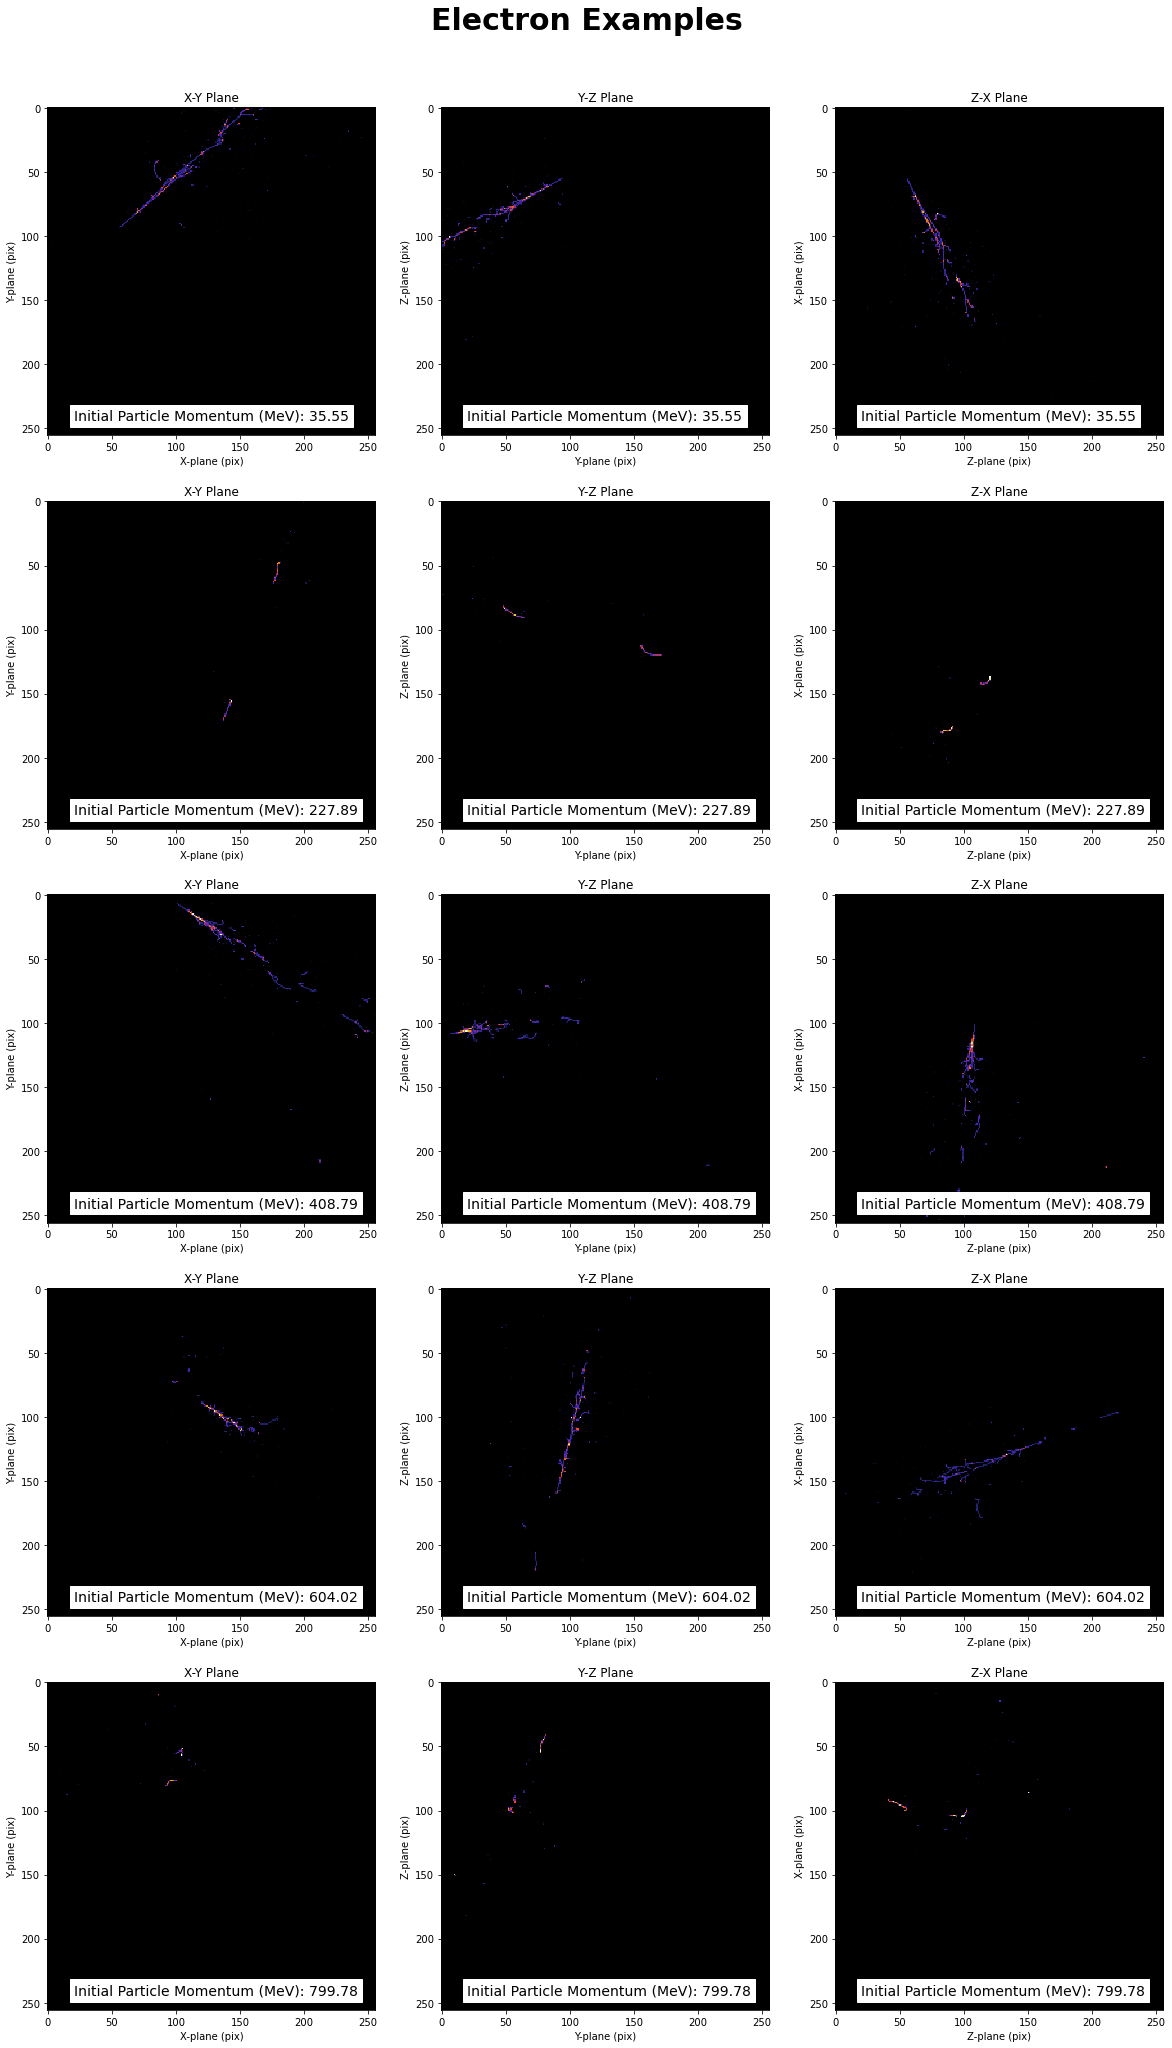

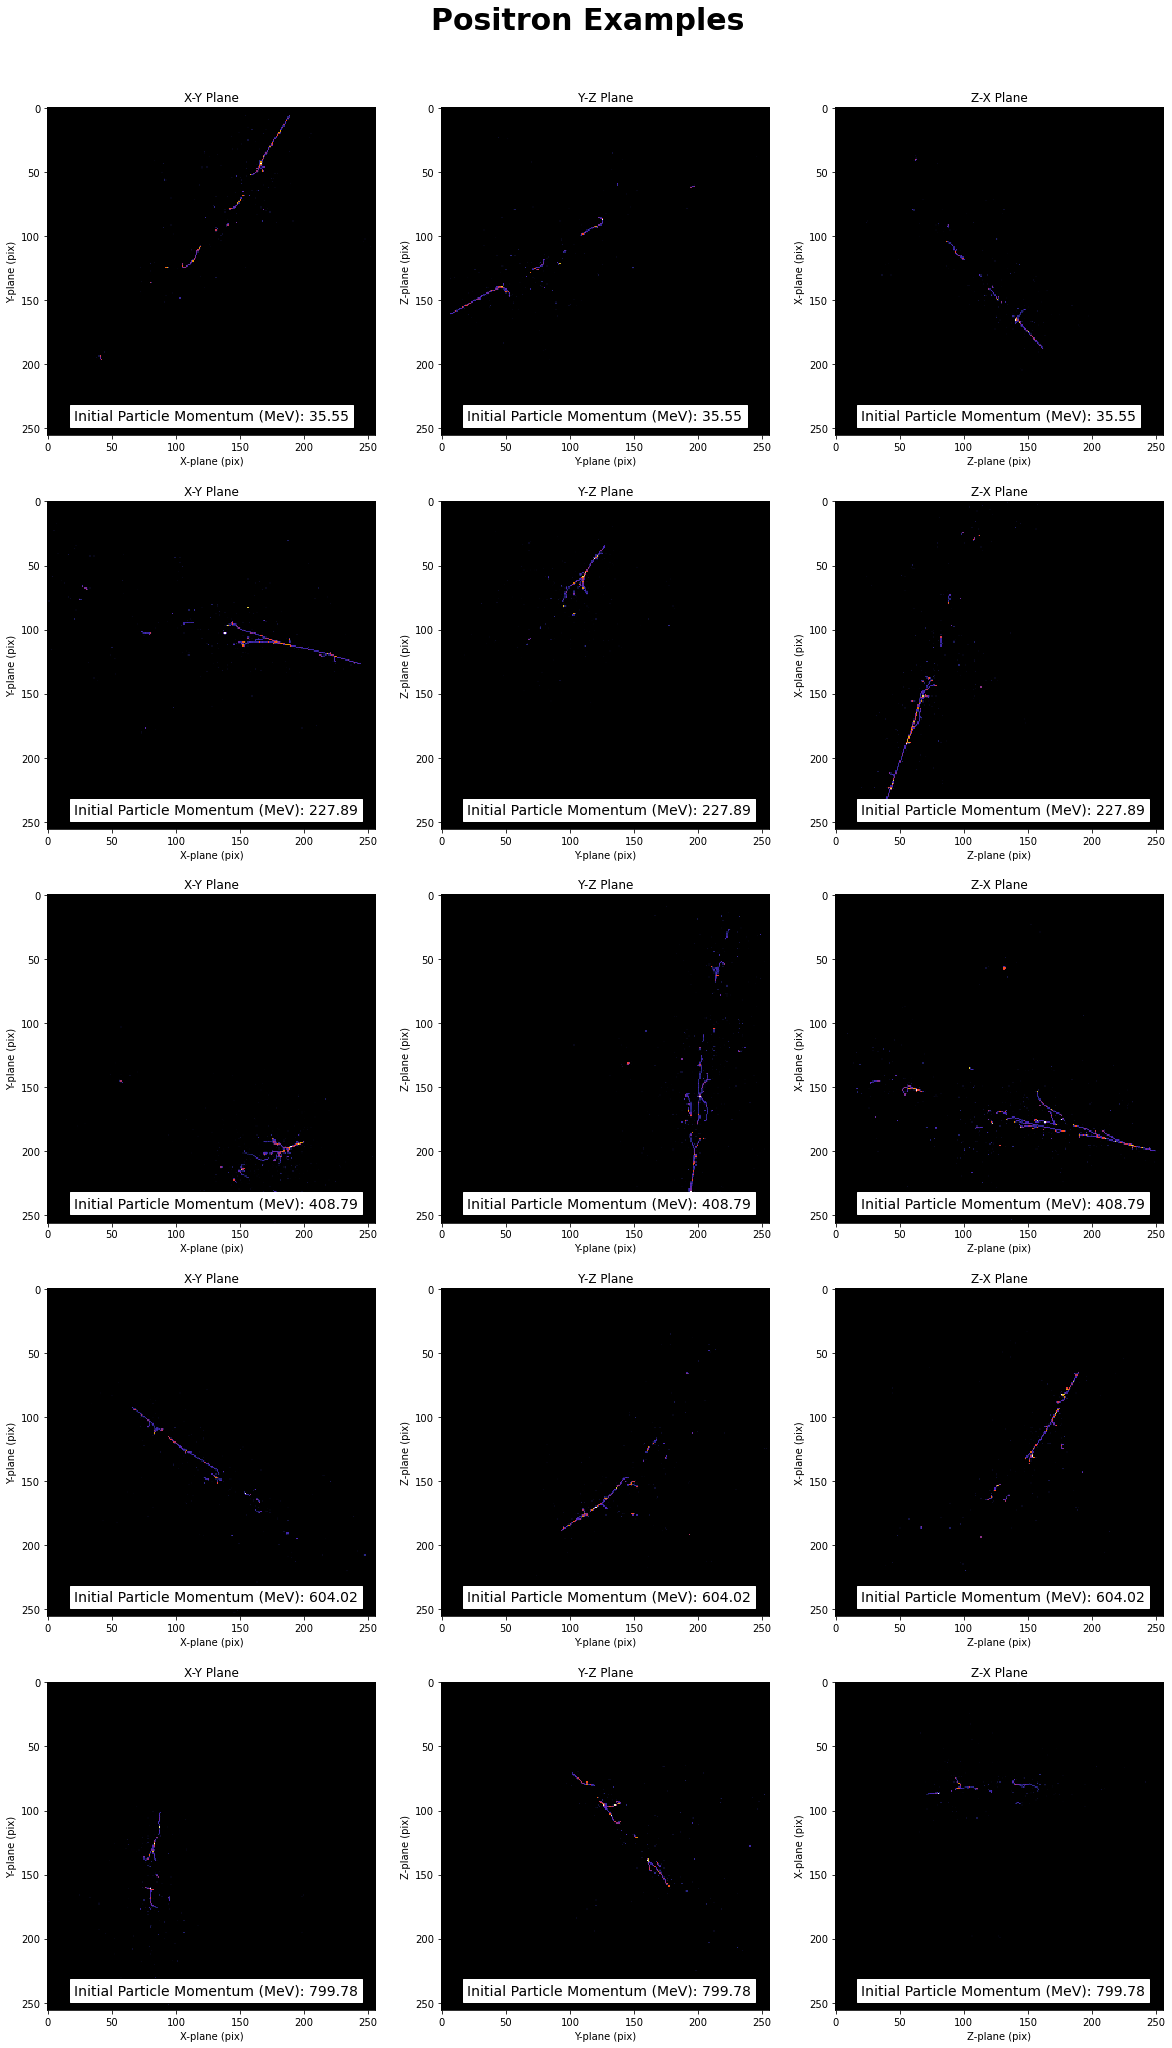

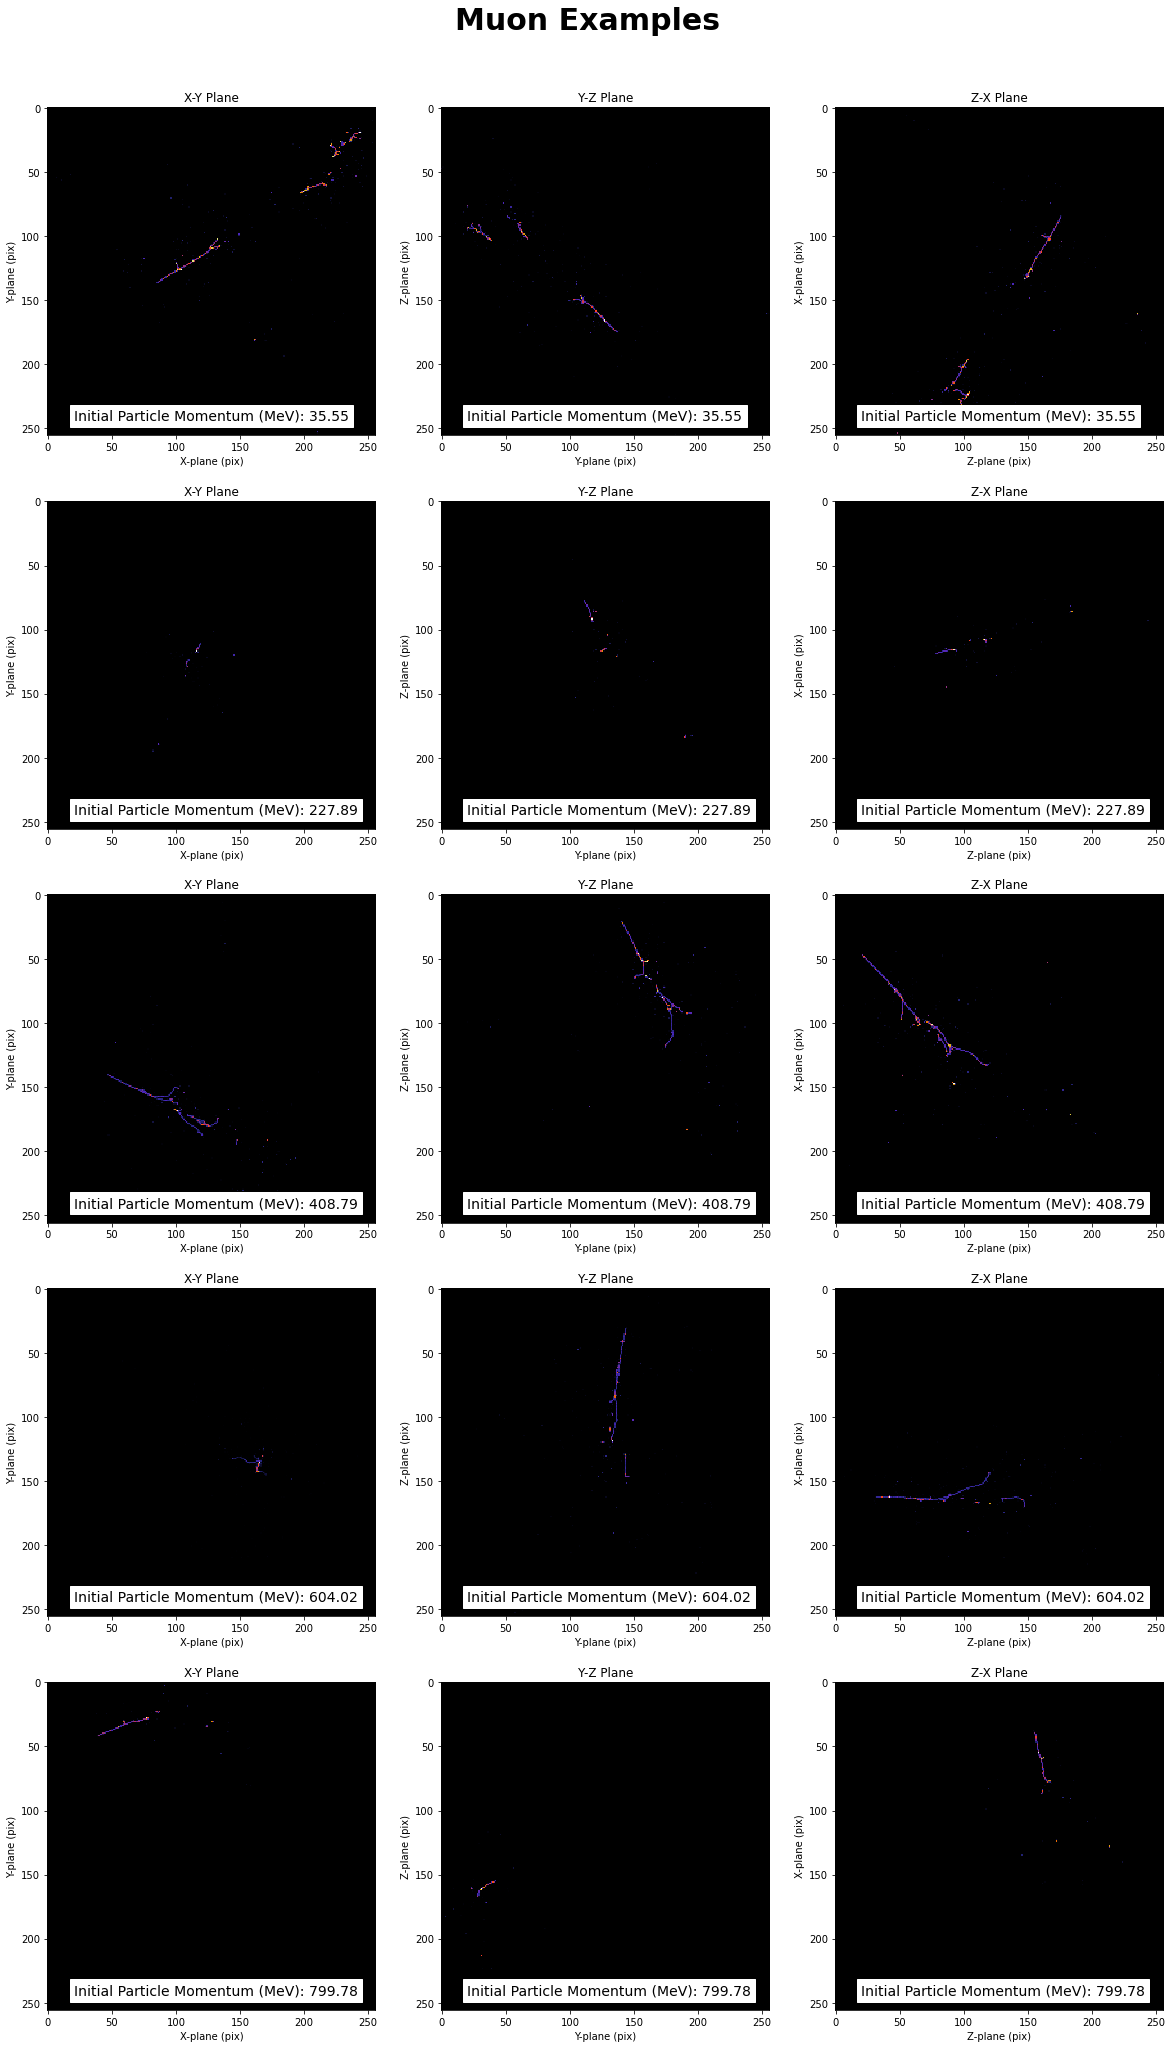

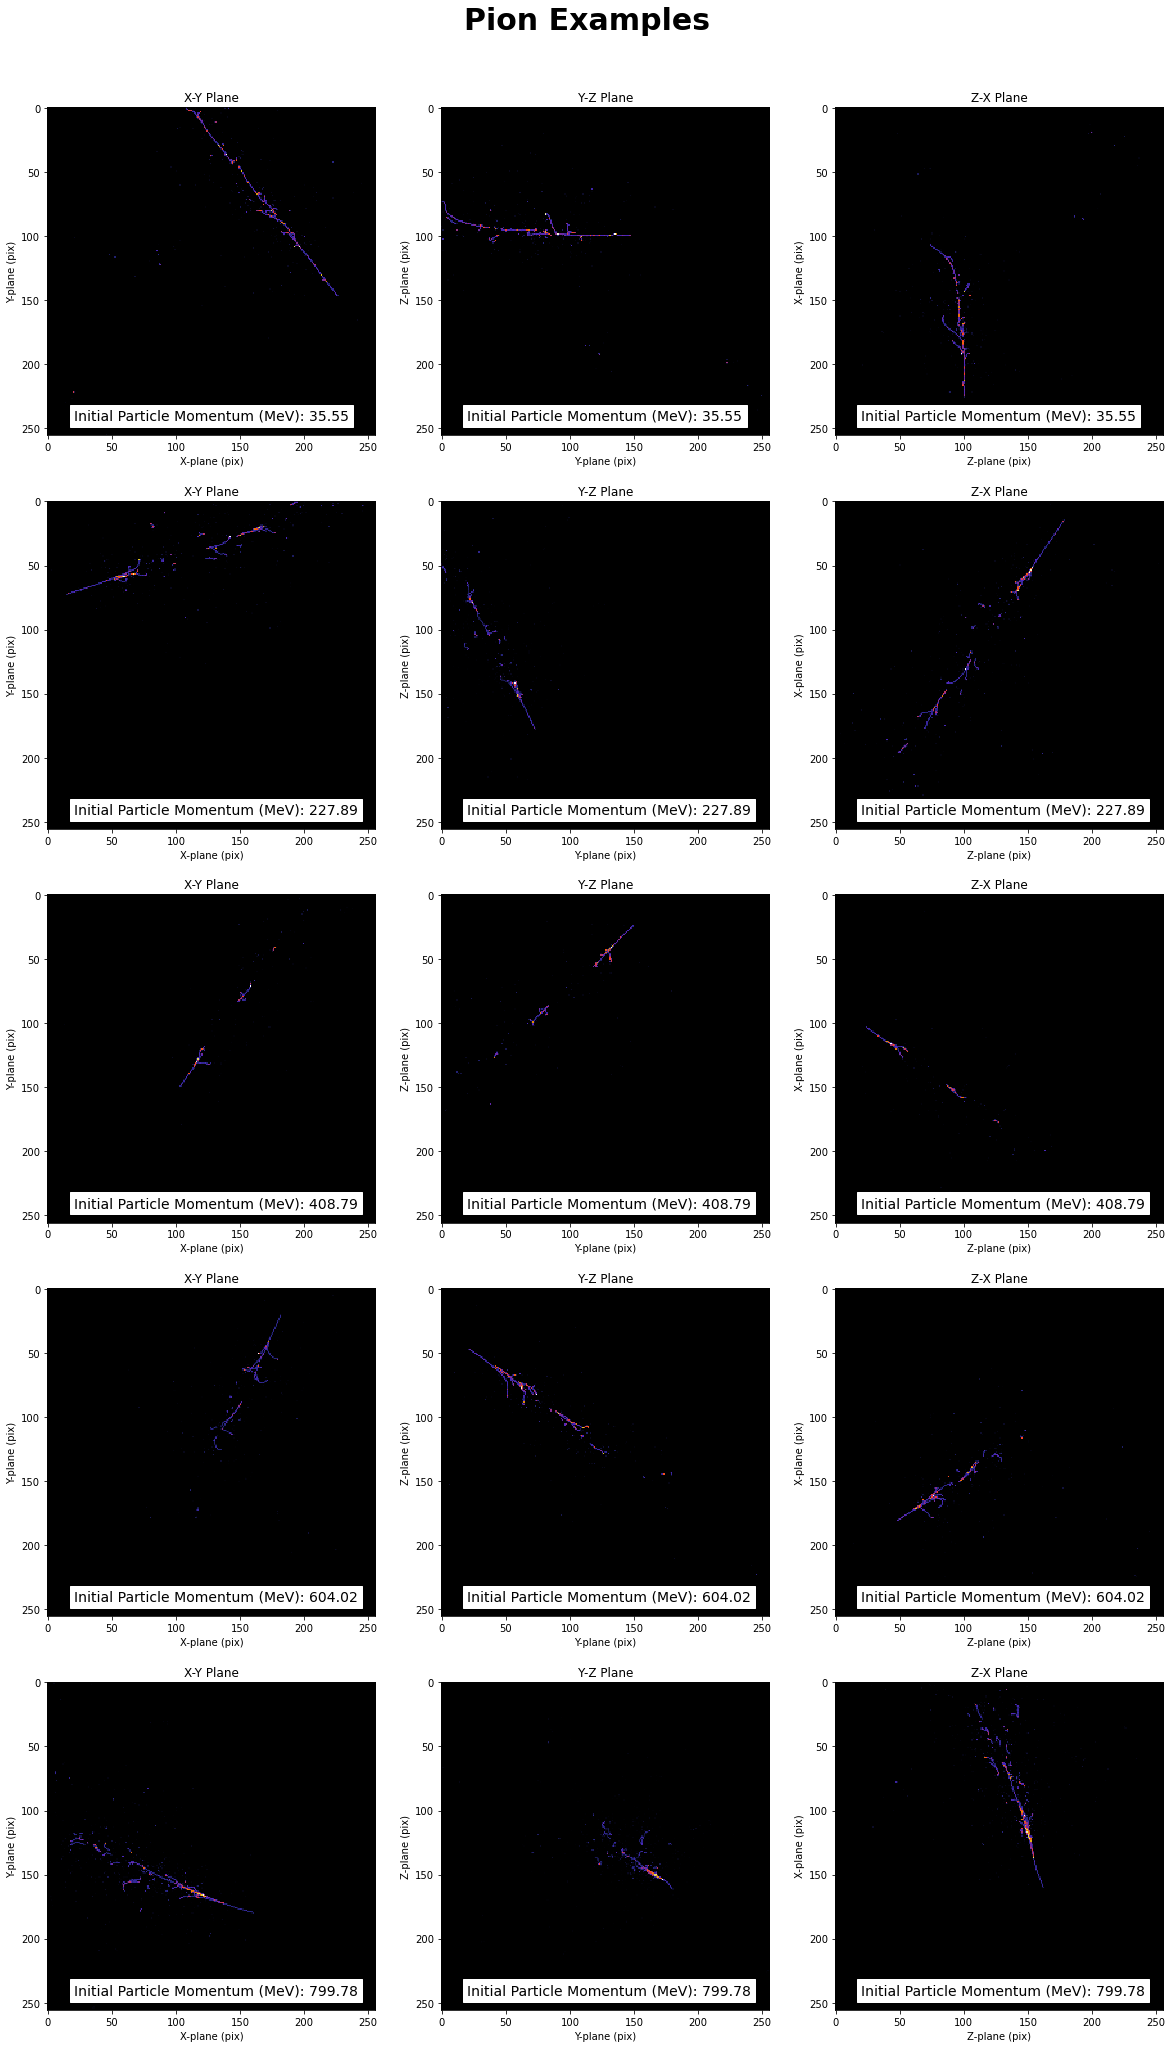

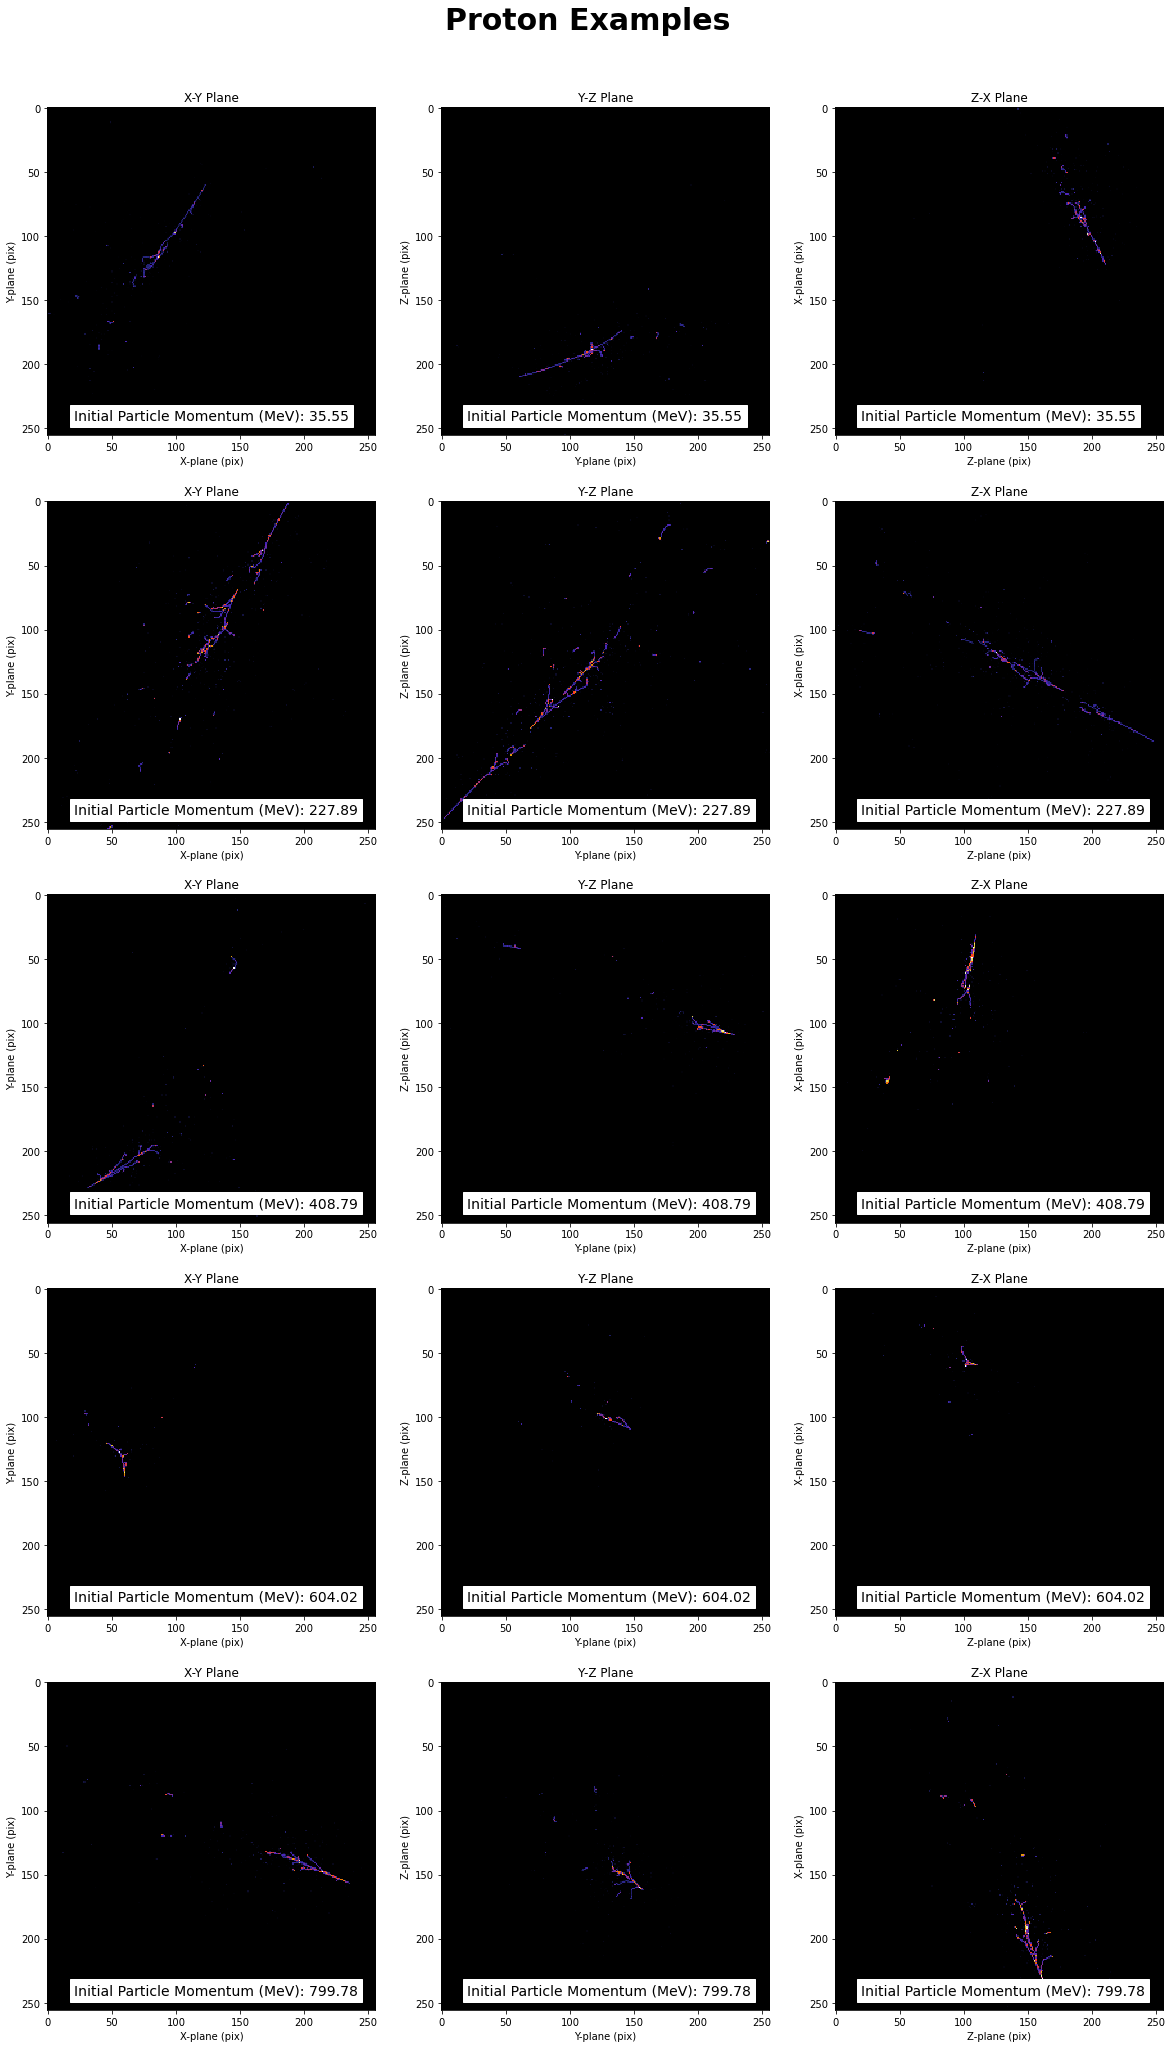

In [16]:
# Looping through the categories and adding the examples found to the sub-plot with a label
for particle_type in range(no_classes):
    fig = plt.figure(figsize=(20, 7*no_examples))
    plt.suptitle(particle_names[particle_type] + " Examples", weight='bold', fontsize=30, y=0.92)

    example_index = 0

    for example in range(no_examples):
        image_index = particle_type*no_examples + example

        for projection_plane in range(no_projections):
            example_index += 1
            fig.add_subplot(no_examples, no_projections, example_index)
            plt.imshow(example_images[image_index][projection_plane], interpolation = 'none', cmap = 'CMRmap')
            plt.xlabel('{}-plane (pix)'.format(projections[projection_plane].split('-')[0]))
            plt.ylabel('{}-plane (pix)'.format(projections[projection_plane].split('-')[1]))
            plt.title(projections[projection_plane] + " Plane")
            plt.text(20, 235, "Initial Particle Momentum (MeV): " + str(np.round_(example_momentums[example], decimals=2)), fontsize=14, backgroundcolor='w', verticalalignment='top')
    plt.show()

## Exploring the Dataset
---

Here the how the truth array data varies for different types of particle is explored. A list of the truth array data names and units is created. Next, the truth array data is looped through, organised by particle type and used to plot histograms.

In [16]:
# Dataset Information about the Truth Arrays
truth_array_info_names = ['Particle ID', 'Total Momentum (MeV)', 'X Momentum Component (MeV)', 'Y Momentum Component (MeV)', 'Z Momentum Component (MeV)', 'X Position of Particle Production (cm)', 'Y Position of Particle Production (cm)', 'Z Position of Particle Production (cm)']

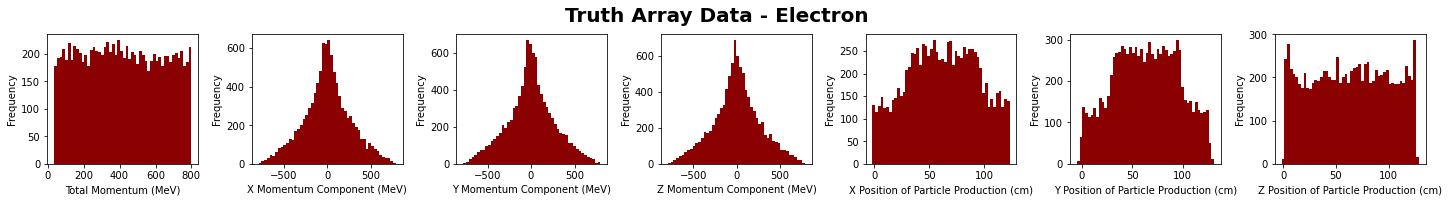

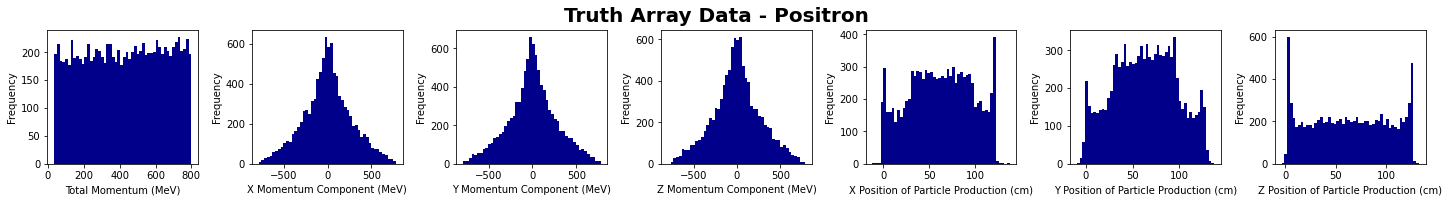

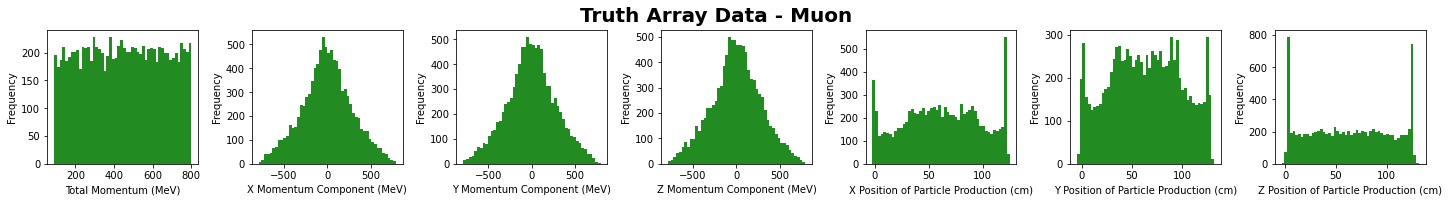

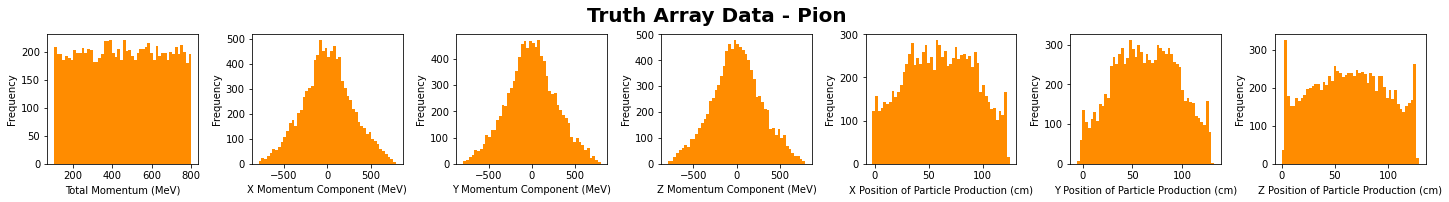

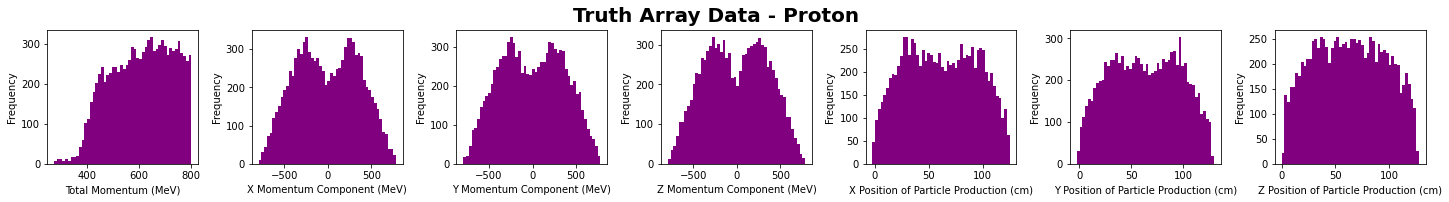

In [17]:
# Plotting histograms for the truth array data separated by particle type
colours = ['darkred', 'darkblue', 'forestgreen', 'darkorange', 'purple']

for particle_type in range(no_classes):
    example_locations = particle_data_indices[particle_type]
    fig = plt.figure(figsize=(20, 3))
    plt.suptitle('Truth Array Data - ' + particle_names[particle_type], weight='bold', fontsize=20, y=0.92)

    for data in range(1, len(truth_array_info_names)):
        fig.add_subplot(1, 7, data)
        plot_data = [float(truth_train[:, data][i]) for i in example_locations]
        plt.hist(plot_data, color = colours[particle_type], bins = 50)
        plt.xlabel(truth_array_info_names[data])
        plt.ylabel("Frequency")
        plt.tight_layout()    
        
plt.show()

## One-Hot Encoding the Dataset 
---
The raw data is assigned numbers that range from 11 - 2212. One hot encoding the data will make things simpler as now the particle type will be assigned a value from 1-5 instead.

In [18]:
# Hot encoding the particle type
type_train = OneHotEncoder(categories="auto", sparse=False, dtype=float).fit_transform(truth_train[:,0].reshape(-1,1))
type_test =  OneHotEncoder(categories="auto", sparse=False, dtype=float).fit_transform(truth_test[:,0].reshape(-1,1))

## Convolution Neural Network Image Classifier 
---

I chose to use a CNN for this problem because of their reputation for high accuracy in image classification problems. As a starting point, I based my first CNN closely on the [MicroBOONE 2020 paper](https://arxiv.org/abs/2010.08653). I chose to run for only 5 epochs as this was just something initial to work with until hyperparameter optimisation. I also used much smaller sizes for convolutional layers than were used in the paper as I wanted to reduce the training time and reversed the structure to make the number of filters increase instead of decrease across the CNN. The CNN layers are as follows:


#### 0 - Reshaping

- Before anything else, the input image needs to be reshaped. The images have been flattened during the transformation to sparse matrices, giving a dimension of 196609 which is the product of (256, 256, 3). They are reshaped to the original dimensions and are now ready for the next step in the CNN.


#### 1 - Convolution Layers

- To create a map of activations (AKA a feature map), convolution layers are implemented. 
- In a convolution layer, filters are applied which result in activations. These activations indicate the strength and location of a detected feature in the input image. 
- In the first convolution layer there is a `strides=2` parameter option which halves the image dimensions. This choice was made to quickly reduce the dimensionality of the input to make training faster and increase feature abundance. 
- All other layers after this have a stride of 1 which menas the dimensions are not reduced during convolution (apart from with the `valid` padding removing pixels from the edges). 
- I chose to structure the convolution layers in sets of two, based on the MicroBOONE paper with increasing filter number. I organised the layers this way as I wanted to reduce the number of trainable parameters to improve training time and so when the image has the most dimensions I used the least amount of filters. 
- The use of a ReLU activation function introduces non-linerality to the CNN and reduces training time as it is a simple, computationally inexpensive function.


#### 2 - Pooling Layers

- The pooling layers purpose is to contract the spatial dimensions of the image, making training faster. 
- Average pooling was chosen over max pooling in reference to the structure used in the MicroBOONE paper.


#### 3 - Dropout Layers

- Dropout regularisation layers are implemented in the CNN to avoid overfitting and stop the first batch of training data disproportionately influencing the training. 
- The first of these layers is placed after the first set of convolutional layers and the second is placed after the first hidden densely connected layer.

#### 4 - Flatten Layer

- Prepares the layer to connect to the dense layers.


#### 5 - Densely Connected Layers

- Finally, hidden densely connected layers are added to perform nonlinear transformations of the inputs entered into the network.
- The first of these has 20 nodes. The number is low because adding more significantly increases the amount of trainable parameters which would have a large impact for training time. 
- The final output dense layer assigns an input image to one of the particle types and therefore has 5 nodes (for 5 particle types) and a sigmoid activation function (because the image either does or does not belong to a certain type).

In [31]:
# Creating an input layer of the correct dimensions for the dataset
input_layer = Input(shape=(196608,))
reshaped_input = Reshape((256, 256, 3))(input_layer)

# Adding a sequence of convolution and pooling layers
convolution_1a = Conv2D(8, kernel_size=3, strides=2, activation='relu')(reshaped_input)
convolution_1b = Conv2D(8, kernel_size=3, strides=1, activation='relu')(convolution_1a)
pool_1 = AveragePooling2D(pool_size=(2, 2))(convolution_1b)
drop_1 = Dropout(0.4)(pool_1)

convolution_2a = Conv2D(16, kernel_size=3, strides=1, activation='relu')(drop_1)
convolution_2b = Conv2D(16, kernel_size=3, strides=1, activation='relu')(convolution_2a)
pool_2 = AveragePooling2D(pool_size=(2, 2))(convolution_2b)

convolution_3a = Conv2D(24, kernel_size=3, strides=1, activation='relu')(pool_2)
convolution_3b = Conv2D(24, kernel_size=3, strides=1, activation='relu')(convolution_3a)
pool_3 = AveragePooling2D(pool_size=(2, 2))(convolution_3b)

# Flattening and connecting the output layers
flat_output = Flatten()(pool_3)
hidden_1 = Dense(20, activation='relu')(flat_output)
drop_2 = Dropout(0.4)(hidden_1)
final_output = Dense(5, activation='sigmoid')(drop_2)
cnn = Model(inputs=input_layer, outputs=final_output)

# Showing the model summary
cnn.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 196608)]          0         
_________________________________________________________________
reshape_5 (Reshape)          (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 127, 127, 8)       224       
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 125, 125, 8)       584       
_________________________________________________________________
average_pooling2d_19 (Averag (None, 62, 62, 8)         0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 62, 62, 8)         0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 60, 60, 16)        1168

### Training Parameters

Before training the model, I set up callbacks to speed up the process as much as possible. In these callbacks the best model over all epochs is also saved for later reloading if necessary. Parameters for the fitting are also set here.

In [19]:
# Variables and callbacks to be used in the training
working_dir = "/Users/olivia/machine-learning-projects"

callback = [EarlyStopping(monitor='loss', patience=3), 
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.01), 
            ModelCheckpoint(os.path.join(working_dir, 'ckpt', 'init_test'), monitor="loss", verbose=0, save_best_only=True, save_weights_only=False, mode="auto", save_freq="epoch")]

validation_slice = 5000
batch_size = 32

### Compilation and Training
The CNN is compiled with the ADAM optimiser and binary cross entropy is used for calculating the loss to be minimised. Accuracy is used for evaluation.
The model is then trained on the image training dataset in small batches fed into the `nn_batch_generator` function, with 5000 examples set apart from the set for validation.

In [33]:
# Compiling and Training
cnn.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])
history_cnn = cnn.fit(nn_batch_generator(x_train[:-validation_slice], type_train[:-validation_slice], batch_size=batch_size),
                      epochs=5, steps_per_epoch=int((50000-validation_slice)/batch_size),
                      validation_data=(x_train[-validation_slice:], type_train[-validation_slice:]), callbacks=callback)

Epoch 1/5
1406/1406 [==============================] - 391s 278ms/step - batch: 702.5000 - size: 32.0000 - loss: 0.4391 - accuracy: 0.8151 - val_loss: 0.3194 - val_accuracy: 0.8445
Epoch 2/5
1406/1406 [==============================] - 404s 287ms/step - batch: 702.5000 - size: 31.9829 - loss: 0.3495 - accuracy: 0.8375 - val_loss: 0.3098 - val_accuracy: 0.8379
Epoch 3/5
1406/1406 [==============================] - 420s 299ms/step - batch: 702.5000 - size: 31.9829 - loss: 0.3301 - accuracy: 0.8426 - val_loss: 0.2973 - val_accuracy: 0.8474
Epoch 4/5
 337/1406 [======>.......................] - ETA: 5:05 - batch: 168.0000 - size: 31.9288 - loss: 0.3114 - accuracy: 0.8468

KeyboardInterrupt: 

### Predicting Labels

After the traning is complete, the CNN is used to predict the particle types of the images from the training set and then the accuracy of the model is calculated with the `evaluate` method.

In [ ]:
# Predicting types and evaluating the accuracy
cnn.predict(nn_batch_generator(x_train[-5000:], type_train[-5000:], batch_size = 50),steps = 5000/50)
cnn.evaluate(nn_batch_generator(x_test, type_test, batch_size = 50), steps = 5000/50)

### Plotting the Loss Curves
Finally, a graph is plotted of the loss.

In [ ]:
# Plotting loss curves
plt.plot(history_cnn.history['loss'], color='DarkBlue', label='Training Loss')
plt.plot(history_cnn.history['val_loss'], color='DarkRed', label='Validatiom Loss')
plt.grid()
plt.title('Loss of CNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Dynamic Convolution Neural Network Builder Function
---

Here I design a function to dynamically create convolutional neural networks with different architectures. The function is based on the structure of the first CNN but it can accept varying numbers of convolution, pooling and dropout layers depending on what is input as well as unique numbers of filters or nodes. I wrote this to enable the automation of hyperparameter optimisation.

In [20]:
def make_cnn(conv_layers, dense_layers, dropout):

    # Creating an input layer of the correct dimensions for the dataset
    input_layer = Input(shape=(196608,))
    reshaped_input = Reshape((256, 256, 3))(input_layer)
    
    # A first convolution and pooling example with a stride
    convolution = Conv2D(conv_layers[0], kernel_size=3, strides=2, activation='relu')(reshaped_input)
    convolution = Conv2D(conv_layers[0], kernel_size=3, strides=1, activation='relu')(convolution)
    pool = AveragePooling2D(pool_size=(2, 2))(convolution)
    pool = Dropout(dropout)(pool)

    # Adding a sequence of convolution and pooling layers with stride = 1
    for c_index in range(1, len(conv_layers)):
        convolution = Conv2D(conv_layers[c_index], kernel_size=3, strides=1, activation='relu')(pool)
        convolution = Conv2D(conv_layers[c_index], kernel_size=3, strides=1, activation='relu')(convolution)
        pool = AveragePooling2D(pool_size=(2, 2))(convolution)
     
    # Flattening the layer (named layer for ease with dense layer function)
    layer = Flatten()(pool)
                                     
    # Adding densely connected layers                                 
    for d_index in range(len(dense_layers)):
        layer = Dense(dense_layers[d_index], activation='relu')(layer)
                                     
    # The layer that classifies  
    layer = Dropout(dropout)(layer)
    final_output = Dense(5, activation='sigmoid')(layer)
    cnn = Model(inputs=input_layer, outputs=final_output)

    # Showing the model summary
    return cnn

## Hyperparameter Optimisation
---

Here I create a Python dictionary with different input values to the `make_cnn()` function and then create a grid with all of the combinations of these values to iterate through. These values are based on the results of my first CNN, which was a relatively accurate starting point.

In [21]:
# Creating a dictinoary of all the combinations of parameters to try
hyper_params = {'conv_layers': [[8, 16, 24], [8, 16, 32, 48], [8, 8, 8, 8]], 'dense_layers': [[20, 20], [50]], 'dropout': [0.2, 0.4]}
params = ParameterGrid(hyper_params)
list(params)

[{'conv_layers': [8, 16, 24], 'dense_layers': [20, 20], 'dropout': 0.2},
 {'conv_layers': [8, 16, 24], 'dense_layers': [20, 20], 'dropout': 0.4},
 {'conv_layers': [8, 16, 24], 'dense_layers': [50], 'dropout': 0.2},
 {'conv_layers': [8, 16, 24], 'dense_layers': [50], 'dropout': 0.4},
 {'conv_layers': [8, 16, 32, 48], 'dense_layers': [20, 20], 'dropout': 0.2},
 {'conv_layers': [8, 16, 32, 48], 'dense_layers': [20, 20], 'dropout': 0.4},
 {'conv_layers': [8, 16, 32, 48], 'dense_layers': [50], 'dropout': 0.2},
 {'conv_layers': [8, 16, 32, 48], 'dense_layers': [50], 'dropout': 0.4},
 {'conv_layers': [8, 8, 8, 8], 'dense_layers': [20, 20], 'dropout': 0.2},
 {'conv_layers': [8, 8, 8, 8], 'dense_layers': [20, 20], 'dropout': 0.4},
 {'conv_layers': [8, 8, 8, 8], 'dense_layers': [50], 'dropout': 0.2},
 {'conv_layers': [8, 8, 8, 8], 'dense_layers': [50], 'dropout': 0.4}]

### Hyperparameter Testing

Next I loop through all of the hyperparameter combinations and train each model on the training dataset. Using callbacks, I save only the best version of each model.

In [23]:
# Looping through the parameters to create and train models
histories = []
working_dir = "/Users/olivia/machine-learning-projects"

for index in range(len(list(params))):
    callback = [EarlyStopping(monitor='loss', patience=3), 
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.01), 
            ModelCheckpoint(os.path.join(working_dir, 'HyperModels', str(index)), monitor="loss", verbose=0, save_best_only=True, save_weights_only=False, mode="auto", save_freq="epoch")]
    model_params = params[index]
    cnn = make_cnn(model_params['conv_layers'], model_params['dense_layers'], model_params['dropout'])
    cnn.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])
    history_cnn = cnn.fit(nn_batch_generator(x_train[:-validation_slice], type_train[:-validation_slice], batch_size=batch_size), epochs=20, steps_per_epoch=int((50000-validation_slice)/batch_size), validation_data=(x_train[-validation_slice:], type_train[-validation_slice:]), callbacks=callback)
    histories.append(history_cnn)

2021-12-09 13:51:04.811346: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-09 13:51:04.830398: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)


Epoch 1/20
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 32.0000 - loss: 0.4708 - accuracy: 0.7857

/opt/anaconda3/envs/daml/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
2021-12-09 13:56:41.262677: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /Users/olivia/Documents/DAML/HyperModels/8/assets
1406/1406 [==============================] - 337s 239ms/step - batch: 702.5000 - size: 32.0000 - loss: 0.4708 - accuracy: 0.7857 - val_loss: 0.3437 - val_accuracy: 0.8295
Epoch 2/20
1406/1406 [==============================] - 349s 249ms/step - batch: 702.5000 - size: 31.9829 - loss: 0.3551 - accuracy: 0.8294 - val_loss: 0.3151 - val_accuracy: 0.8376
Epoch 3/20
1406/1406 [==============================] - 351s 250ms/step - batch: 702.5000 - size: 31.9829 - loss: 0.3282 - accuracy: 0.8363 - val_loss: 0.3072 - val_accuracy: 0.8388
Epoch 4/20
1406/1406 [==============================] - 355s 252ms/step - batch: 702.5000 - size: 31.9829 - loss: 0.3178 - accuracy: 0.8387 - val_loss: 0.2963 - val_accuracy: 0.8439
Epoch 5/20
1406/1406 [==============================] - 356s 253ms/step - batch: 702.5000 - size: 31.9829 - loss: 0.3123 - accuracy: 0.8391 - val_loss: 0.2781 - val_accuracy: 0.8477
Epoch 6/20
1406/

/opt/anaconda3/envs/daml/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Epoch 1/20
1406/1406 [==============================] - 380s 270ms/step - batch: 702.5000 - size: 32.0000 - loss: 0.5743 - accuracy: 0.7988 - val_loss: 0.5148 - val_accuracy: 0.8000
Epoch 2/20
1406/1406 [==============================] - 372s 265ms/step - batch: 702.5000 - size: 31.9829 - loss: 0.5045 - accuracy: 0.8000 - val_loss: 0.5008 - val_accuracy: 0.8000
Epoch 3/20
1406/1406 [==============================] - 375s 267ms/step - batch: 702.5000 - size: 31.9829 - loss: 0.5005 - accuracy: 0.8000 - val_loss: 0.5005 - val_accuracy: 0.8000
Epoch 4/20
1406/1406 [==============================] - 364s 259ms/step - batch: 702.5000 - size: 31.9829 - loss: 0.5004 - accuracy: 0.8000 - val_loss: 0.5005 - val_accuracy: 0.8000
Epoch 5/20
1406/1406 [==============================] - 371s 264ms/step - batch: 702.5000 - size: 31.9829 - loss: 0.5004 - accuracy: 0.8000 - val_loss: 0.5005 - val_accuracy: 0.8000
Epoch 6/20
1406/1406 [==============================] - 386s 275ms/step - batch: 702.5000 

/opt/anaconda3/envs/daml/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Epoch 1/20
1406/1406 [==============================] - 387s 275ms/step - batch: 702.5000 - size: 32.0000 - loss: 0.5030 - accuracy: 0.7914 - val_loss: 0.4085 - val_accuracy: 0.8244
Epoch 2/20
1406/1406 [==============================] - 357s 254ms/step - batch: 702.5000 - size: 31.9829 - loss: 0.3722 - accuracy: 0.8243 - val_loss: 0.3020 - val_accuracy: 0.8370
Epoch 3/20
1406/1406 [==============================] - 374s 266ms/step - batch: 702.5000 - size: 31.9829 - loss: 0.3370 - accuracy: 0.8298 - val_loss: 0.2905 - val_accuracy: 0.8420
Epoch 4/20
1406/1406 [==============================] - 361s 257ms/step - batch: 702.5000 - size: 31.9829 - loss: 0.3239 - accuracy: 0.8361 - val_loss: 0.2917 - val_accuracy: 0.8443
Epoch 5/20
1406/1406 [==============================] - 375s 267ms/step - batch: 702.5000 - size: 31.9829 - loss: 0.3173 - accuracy: 0.8384 - val_loss: 0.2761 - val_accuracy: 0.8505
Epoch 6/20
1406/1406 [==============================] - 380s 270ms/step - batch: 702.5000 

/opt/anaconda3/envs/daml/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Epoch 1/20
1406/1406 [==============================] - 389s 276ms/step - batch: 702.5000 - size: 32.0000 - loss: 0.4768 - accuracy: 0.7986 - val_loss: 0.4052 - val_accuracy: 0.8123
Epoch 2/20
1406/1406 [==============================] - 374s 266ms/step - batch: 702.5000 - size: 31.9829 - loss: 0.4110 - accuracy: 0.8182 - val_loss: 0.3738 - val_accuracy: 0.8221
Epoch 3/20
1406/1406 [==============================] - 365s 259ms/step - batch: 702.5000 - size: 31.9829 - loss: 0.3923 - accuracy: 0.8210 - val_loss: 0.3490 - val_accuracy: 0.8265
Epoch 4/20
1406/1406 [==============================] - 375s 267ms/step - batch: 702.5000 - size: 31.9829 - loss: 0.3841 - accuracy: 0.8225 - val_loss: 0.3481 - val_accuracy: 0.8235
Epoch 5/20
1406/1406 [==============================] - 376s 268ms/step - batch: 702.5000 - size: 31.9829 - loss: 0.3765 - accuracy: 0.8235 - val_loss: 0.3321 - val_accuracy: 0.8270
Epoch 6/20
1406/1406 [==============================] - 369s 262ms/step - batch: 702.5000 

/opt/anaconda3/envs/daml/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


### Loading Saved Models
I load in the best model for each hyperparameter configuration and use the `evaluate` method to measure the accuracy on the testing dataset. This is then presented in a table for readability.

In [22]:
# Loading and evaluating the saved models to help with selection
losses = []
accuracies = []

for model_no in range(len(list(params))):
    model = load_model("/Users/olivia/machine-learning-projects/HyperModels/" + str(model_no))
    loss, accuracy = model.evaluate(nn_batch_generator(x_test, type_test, batch_size=50),steps=5000/50)
    losses.append(loss)
    accuracies.append(accuracy) 

2021-12-10 08:36:38.227029: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-10 08:36:38.256444: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:196] None of the MLIR optimization passes are enabled (registered 0 passes)
/opt/anaconda3/envs/daml/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


In [23]:
# Creating a table to visualise the model performance
table_data = pd.DataFrame({'Accuracy': accuracies,
                           'Loss': losses})
table = pd.concat([table_data, pd.DataFrame(params)], axis=1)
table.columns = ['Accuracy', 'Loss', 'Convolution', 'Dense', 'Dropout']

### Performance of Tested Models
Models with the higher dropout rate of 0.4 generally perfomed worse compared to those with lower dropout rates. For some of the models, training stopped before 20 epochs as the loss got stuck at around 0.5 (see models 4 and 9). The 3 best models in terms accuracy appeared to be 0, 2, and 6 so I chose to run these again in an attempt to see their entire loss history.

In [24]:
print(table)   

    Accuracy      Loss      Convolution     Dense  Dropout
0    0.86984  0.237275      [8, 16, 24]  [20, 20]      0.2
1    0.84932  0.274886      [8, 16, 24]  [20, 20]      0.4
2    0.85528  0.253303      [8, 16, 24]      [50]      0.2
3    0.83156  0.326649      [8, 16, 24]      [50]      0.4
4    0.80000  0.500443  [8, 16, 32, 48]  [20, 20]      0.2
5    0.85340  0.253809  [8, 16, 32, 48]  [20, 20]      0.4
6    0.85908  0.240104  [8, 16, 32, 48]      [50]      0.2
7    0.85040  0.317933  [8, 16, 32, 48]      [50]      0.4
8    0.85068  0.248088     [8, 8, 8, 8]  [20, 20]      0.2
9    0.80000  0.500443     [8, 8, 8, 8]  [20, 20]      0.4
10   0.85404  0.254017     [8, 8, 8, 8]      [50]      0.2
11   0.84764  0.279266     [8, 8, 8, 8]      [50]      0.4


## Second Hyperparameter Optimisation

---

In [25]:
# Selecting only the best 3 models
best_params = [params[0], params[2], params[6]]
list(best_params)

[{'dropout': 0.2, 'dense_layers': [20, 20], 'conv_layers': [8, 16, 24]},
 {'dropout': 0.2, 'dense_layers': [50], 'conv_layers': [8, 16, 24]},
 {'dropout': 0.2, 'dense_layers': [50], 'conv_layers': [8, 16, 32, 48]}]

In [27]:
# Re-running the loop with the best three models
working_dir = "/Users/olivia/machine-learning-projects"

for index in range(len(list(best_params))):
    callback = [EarlyStopping(monitor='loss', patience=3), 
            ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.01), 
            ModelCheckpoint(os.path.join(working_dir, "TopParamModels", str(index)), monitor="loss", verbose=0, save_best_only=True, save_weights_only=False, mode="auto", save_freq="epoch")]
    model_params = best_params[index]
    cnn = make_cnn(model_params['conv_layers'], model_params['dense_layers'], model_params['dropout'])
    cnn.compile('adam', loss='binary_crossentropy', metrics=['accuracy'])
    history_cnn = cnn.fit(nn_batch_generator(x_train[:-validation_slice], type_train[:-validation_slice], batch_size=batch_size), epochs=20, steps_per_epoch=int((50000-validation_slice)/batch_size), validation_data=(x_train[-validation_slice:], type_train[-validation_slice:]), callbacks=callback)
    hist_df = pd.DataFrame(history_cnn.history)
    with open(os.path.join(working_dir, 'History', str(index), "hist.txt"), "w") as file:
         hist_df.to_csv(file)

Epoch 1/20
1406/1406 [==============================] - ETA: 0s - batch: 702.5000 - size: 32.0000 - loss: 0.3326 - accuracy: 0.8396

/opt/anaconda3/envs/daml/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2323: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
2021-12-10 08:46:43.083925: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /Users/olivia/Documents/DAML/TopParamModels/2/assets
1406/1406 [==============================] - 386s 273ms/step - batch: 702.5000 - size: 32.0000 - loss: 0.3326 - accuracy: 0.8396 - val_loss: 0.2589 - val_accuracy: 0.8643
Epoch 2/20
1406/1406 [==============================] - 384s 273ms/step - batch: 702.5000 - size: 31.9829 - loss: 0.2622 - accuracy: 0.8629 - val_loss: 0.2417 - val_accuracy: 0.8719
Epoch 3/20
1406/1406 [==============================] - 388s 276ms/step - batch: 702.5000 - size: 31.9829 - loss: 0.2453 - accuracy: 0.8712 - val_loss: 0.2364 - val_accuracy: 0.8787
Epoch 4/20
1406/1406 [==============================] - 394s 280ms/step - batch: 702.5000 - size: 31.9829 - loss: 0.2354 - accuracy: 0.8778 - val_loss: 0.2327 - val_accuracy: 0.8823
Epoch 5/20
1406/1406 [==============================] - 408s 290ms/step - batch: 702.5000 - size: 31.9829 - loss: 0.2282 - accuracy: 0.8840 - val_loss: 0.2337 - val_accuracy: 0.8833
Epoch 6/20
14

### Accuracies of Models

In [77]:
# Evaluating the accuracy
best_losses = []
best_accuracies = []

for model_no in range(len(list(best_params))):
    model = load_model("/Users/olivia/machine-learning-projects/TopParamModels/" + str(model_no))
    loss, accuracy = model.evaluate(nn_batch_generator(x_test, type_test, batch_size=50),steps=5000/50)
    best_losses.append(loss)
    best_accuracies.append(accuracy) 

In [89]:
# Presenting the data in a table
best_table_data = pd.DataFrame({'Accuracy': best_accuracies,
                           'Loss': best_losses})
best_table = pd.concat([best_table_data, pd.DataFrame(best_params)], axis=1)
best_table.columns = ['Accuracy', 'Loss', 'Dropout', 'Dense', 'Convolution']

In [90]:
print(best_table)   

   Accuracy      Loss  Dropout     Dense      Convolution
0   0.90212  0.238706      0.2  [20, 20]      [8, 16, 24]
1   0.90620  0.224704      0.2      [50]      [8, 16, 24]
2   0.91072  0.219656      0.2      [50]  [8, 16, 32, 48]


### Loading and Plotting Loss/Accuracy For Best Model

Here I load the textfile into a dataframe and then use this to plot grpahs of the loss and accuracy over the epochs.

In [74]:
data_6 = pd.read_csv("/Users/olivia/machine-learning-projects/History/2/hist.txt", index_col=0, squeeze=True)

In [75]:
data_6

,loss,accuracy,val_loss,val_accuracy,lr
0,0.332648,0.839585,0.258855,0.86432,0.001
1,0.262170,0.862938,0.241692,0.87192,0.001
2,0.245281,0.871232,0.236446,0.87868,0.001
3,0.235377,0.877794,0.232740,0.88228,0.001
4,0.228152,0.883989,0.233671,0.88332,0.001
5,0.221018,0.890091,0.238680,0.88252,0.001
6,0.213889,0.896014,0.224747,0.89116,0.001
7,0.204988,0.904024,0.218022,0.89324,0.001
8,0.198638,0.907761,0.197993,0.90712,0.001
9,0.191848,0.912343,0.195026,0.90784,0.001


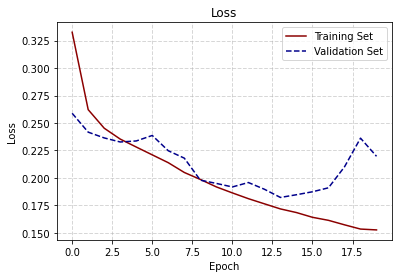

In [85]:
# Getting the loss curves from the training history
loss = data_6['loss']
val_loss = data_6['val_loss']

# Plotting the loss curves and accuracy
plt.figure(figsize=(6, 4))
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(loss, label='Training Set', color='darkred')
plt.plot(val_loss, label='Validation Set', linestyle='--', color='darkblue')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)
plt.show()

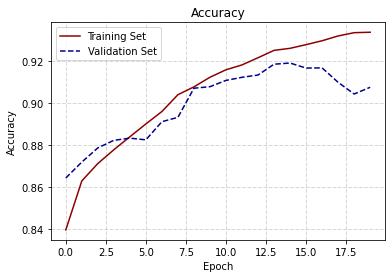

In [88]:
# Getting the loss curves from the training history
acc = data_6['accuracy']
val_acc = data_6['val_accuracy']

# Plotting the loss curves and accuracy
plt.figure(figsize=(6, 4))
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(acc, label='Training Set', color='darkred')
plt.plot(val_acc, label='Validation Set', linestyle='--', color='darkblue')
plt.legend()
plt.grid(linestyle='--', linewidth=1, alpha=0.5)
plt.show()

## Classifications Using the Model
---

Here the optimised model  is loaded and used to predict the types of particles from the test images. It is evaluated for the accuracy of the test set.

In [131]:
# Loading the final model, predicting labels and evaluating accuracy
final_model = load_model("/Users/olivia/machine-learning-projects/TopParamModels/2")

type_predictions = final_model.predict(nn_batch_generator(x_test, type_test,batch_size=50),steps=40000/50)
loss, accuracy = final_model.evaluate(nn_batch_generator(x_test, type_test,batch_size=50),steps=40000/50)

In [132]:
print(accuracy)

0.9103797


### Converting from Hot-Encoding to Integers 
I convert the particle type data to integers for easier use in loops and graphs.

In [133]:
# Taking the index where 1 is in the hot-encoded matrix
int_types_test = np.argmax(type_test, axis=1)
int_types_predictions = np.argmax(type_predictions, axis=1)

print(int_types_test[0:20])
print(int_types_predictions[0:20])

[1 0 0 4 3 2 4 2 3 3 3 2 1 2 3 3 4 0 0 4]
[1 2 0 4 3 2 4 0 3 3 2 2 1 0 4 3 4 0 0 4]


## Classification Examples
___

Below a few of the first testing examples are plotted, with red indicating a misclassification and green a correct label.

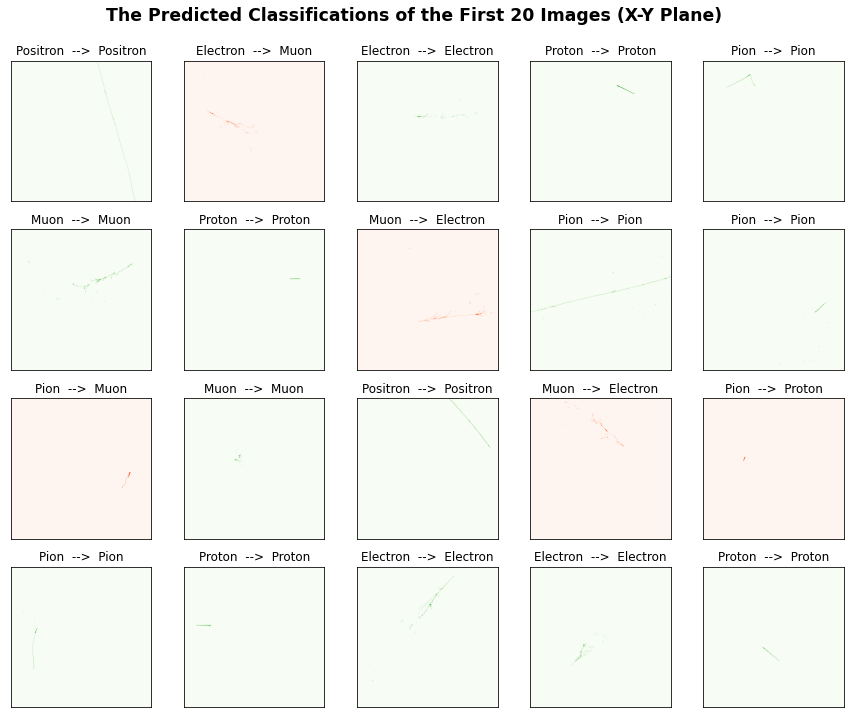

In [197]:
# Showing the classifications of the first 12 images in the test set
no_images = 20
num_cells = math.ceil(math.sqrt(no_images))
plt.figure(figsize=(15, 15))

# Running through the desired no. of images and getting the correct and predicted labels for each one
for image_index in range(no_images):
    # Re-shaping the flattened image
    pixels = toimage(x_test[image_index])[0]
    
    # Getting the labels and names of the labels
    y_correct = int(int_types_test[image_index])
    y_predicted = int(int_types_predictions[image_index])
    correct_label = particle_names[y_correct]
    predicted_label = particle_names[y_predicted]

    # Plotting the image with it's labels and a color map to indicated correct matches
    color_map = 'Greens' if y_correct == y_predicted else 'Reds'
    plt.subplot(num_cells, num_cells, image_index + 1)
    plt.imshow(pixels, cmap=color_map)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.title(correct_label + '  -->  ' + predicted_label)
    
plt.suptitle('The Predicted Classifications of the First 20 Images (X-Y Plane)', y=0.93, weight='bold', size='xx-large')    
plt.show()

## Confusion Matrix
---

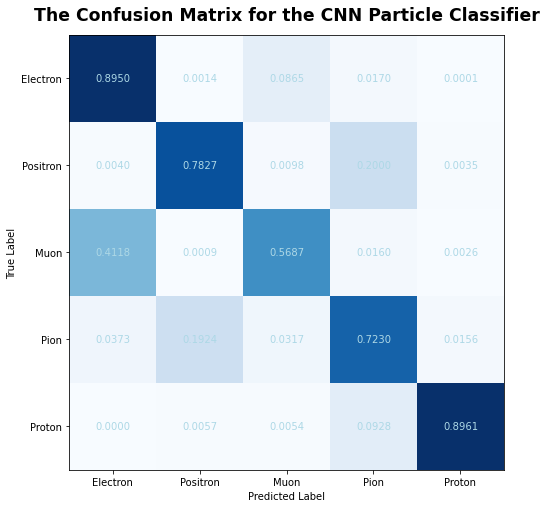

In [139]:
# Calculating and plotting the confusion matrix with intensity labels
confusion = confusion_matrix(int_types_test.tolist(), int_types_predictions.tolist(), normalize='true')
plt.figure(figsize=(8, 8))
plt.imshow(confusion, cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(5), labels=particle_names)
plt.yticks(np.arange(5), labels=particle_names)
plt.title('The Confusion Matrix for the CNN Particle Classifier', y=1.02, weight='bold', size='xx-large')

# Adding intensity labels
for y in range(confusion.shape[0]):
   for x in range(confusion.shape[1]):
      plt.text(x, y, '%.4f' % confusion[y, x],
         horizontalalignment='center',
         verticalalignment='center', color='lightblue')

plt.show()

### Mis-Classified Particles - Momenta and Position Values
---

In order to see if the model misclassification had any dependence on momenta and postion values, truth array histograms are plotted separated by particle type for only the misclassified data.

In [314]:
# Getting indexes of misclassified data
misclassified = []

for image_index in range(len(int_types_test)):
    # Getting the labels and names of the labels
    y_correct = int(int_types_test[image_index])
    y_predicted = int(int_types_predictions[image_index])

    if y_correct == y_predicted:
        pass
    else:
        misclassified.append(image_index)

In [315]:
misclassified = np.array(misclassified)

In [316]:
# Getting indices of different particle types
particle_test_indices = []
for particle_type in range(no_classes):
    particle_test_indices.append(np.argwhere(truth_test[misclassified,0]==particle_IDs[particle_type]))

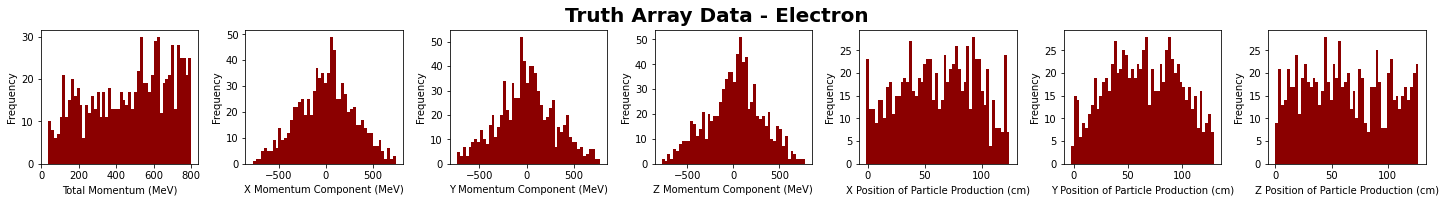

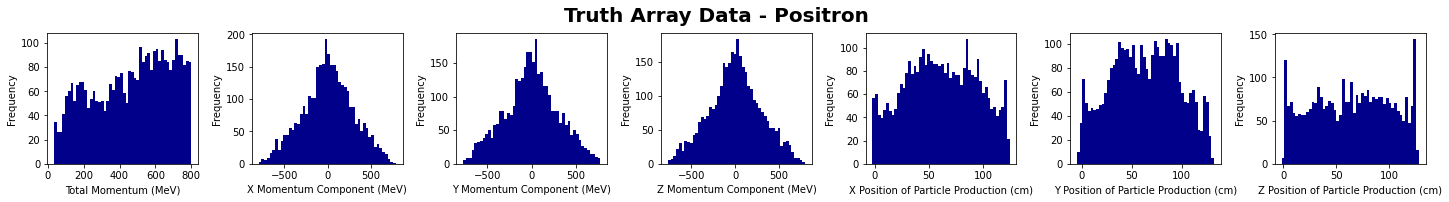

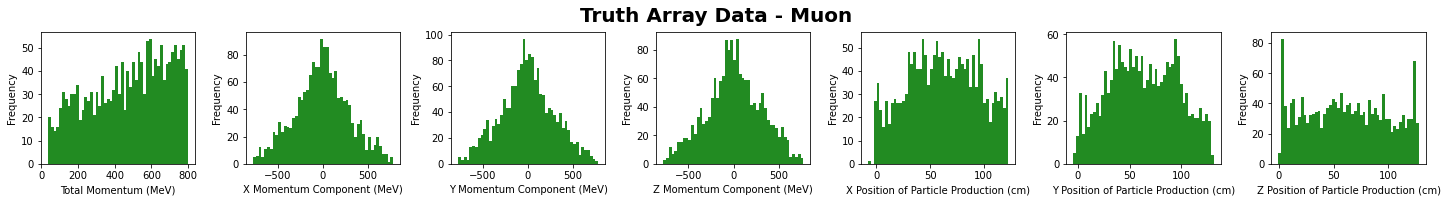

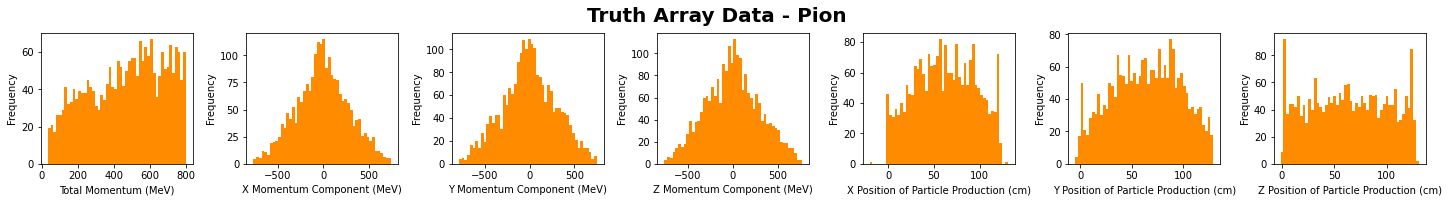

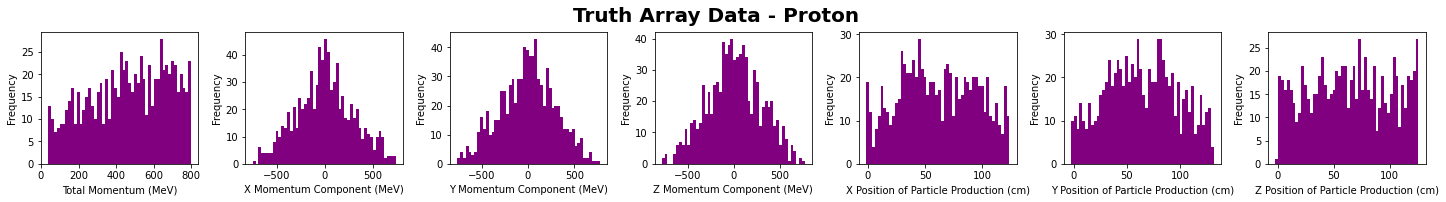

In [317]:
# Plotting histograms for misclassification truth array data
for particle_type in range(no_classes):
    example_locations = particle_test_indices[particle_type]
    fig = plt.figure(figsize=(20, 3))
    plt.suptitle('Truth Array Data - ' + particle_names[particle_type], weight='bold', fontsize=20, y=0.92)
    for data in range(1, len(truth_array_info_names)):
        fig.add_subplot(1, 7, data)
        plot_data = [float(truth_test[:, data][i]) for i in example_locations]
        plt.hist(plot_data, color=colours[particle_type], bins=50)
        plt.xlabel(truth_array_info_names[data])
        plt.ylabel("Frequency")
        plt.tight_layout()    
    
plt.show()

## Discussion of Results
___  
    
From the confusion matrix we can see that electrons and protons are the easiest to identify, with around 90% accuracy for each on the testing data. There is a large amount of mis-classification for electrons as muons and also for pions and positrons as each other. The model overall has relatively good particle purity.

Some particles are similar because they are either close in mass or have the same charge (i.e electron and positron or proton and positron). This may be why the muon had such a high misclassification as an electron. Both of the particles are similar, with the same charge and spin.

It seems as though for all particles, there is higher misclassification rates at high total momentums. For protons, high absolute values of x, y, and z momentum lead to lower misclassification. There is also a general trend of higher misclassification for mid-values of x, y, and z positions.